# Import the libraries that are necesaries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import getpass  # To get the password without showing the input
from sqlalchemy import create_engine, text
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import nltk
from nltk.corpus import stopwords
from pycaret.regression import *
import pickle

Connect to MySQL

In [2]:
password = getpass.getpass()
user = 'root'
database_name = 'steam_games'
connection_string = f'mysql+pymysql://{user}:' + password + '@localhost/' + database_name
engine = create_engine(connection_string)

# 1. Game Popularity vs. Features:
- *Theory*: Peak concurrent users (peak_ccu) of games are generally higher when their estimated owners are higher.
- *Analysis*: Peak_ccu and estimated owners' correlation with one another.

In [3]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT
                appid,
                estimated_owners,
                peak_ccu
            FROM
                game;'''
    query = text(txt)
    result = connection.execute(query)
    game_df = pd.DataFrame(result.all())

game_df

,appid,estimated_owners,peak_ccu
0,10,15000000.0,13230.0
1,20,7500000.0,110.0
2,30,7500000.0,106.0
3,40,7500000.0,2.0
4,50,7500000.0,120.0
...,...,...,...
85098,2760980,0.0,0.0
85099,2761170,0.0,0.0
85100,2763480,0.0,0.0
85101,2764930,0.0,0.0


Normalize the dataset

In [4]:
# Fill NaN values with an empty string (if needed)
game_df = game_df.fillna('')

# Normalize numerical features using StandardScaler
numerical_columns = game_df.select_dtypes(include=['float64', 'int64']).columns.difference(['appid'])
scaler = StandardScaler()
game_df[numerical_columns] = scaler.fit_transform(game_df[numerical_columns])

Setup the data for modeling

In [5]:
# Initialize PyCaret
reg_setup = setup(
    data=game_df,
    target='estimated_owners',
    train_size=0.8,
    session_id=42,
    numeric_features=['peak_ccu']
)

# Compare different regression models
reg_models = compare_models()

,Description,Value
0,Session id,42
1,Target,estimated_owners
2,Target type,Regression
3,Original data shape,"(85103, 3)"
4,Transformed data shape,"(85103, 3)"
5,Transformed train set shape,"(68082, 3)"
6,Transformed test set shape,"(17021, 3)"
7,Numeric features,1
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.0689,0.5959,0.7198,0.3773,0.1074,0.7444,0.4810
rf,Random Forest Regressor,0.0713,0.6321,0.7415,0.3655,0.1173,0.8173,1.7440
lightgbm,Light Gradient Boosting Machine,0.0733,0.6562,0.7570,0.3182,0.1213,0.7655,0.1330
et,Extra Trees Regressor,0.0756,0.7122,0.7850,0.2734,0.1233,0.8494,0.6860
lr,Linear Regression,0.1283,0.6959,0.7897,0.2316,0.1418,1.4256,0.4390
ridge,Ridge Regression,0.1283,0.6959,0.7897,0.2316,0.1418,1.4257,0.0130
lar,Least Angle Regression,0.1283,0.6959,0.7897,0.2316,0.1418,1.4256,0.0140
br,Bayesian Ridge,0.1283,0.6959,0.7897,0.2316,0.1418,1.4257,0.0140
en,Elastic Net,0.1418,1.0936,0.9462,0.0448,0.1553,1.5944,0.0130
lasso,Lasso Regression,0.1441,1.1215,0.9609,0.0120,0.1618,1.6247,0.3270


In [6]:
# Create a Gradient Boosting Regressor model
gbm_model = create_model('gbr')

# Tune the Gradient Boosting Regressor model
tuned_gbm_model = tune_model(gbm_model)

# Evaluate the tuned model
evaluate_model(tuned_gbm_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0705,0.8332,0.9128,0.7978,0.1032,0.7908
1,0.0574,0.3353,0.5791,0.4870,0.0892,0.7411
2,0.0581,0.2083,0.4564,0.4736,0.1010,0.6996
3,0.0858,1.1834,1.0879,0.0098,0.1222,0.8253
4,0.0799,0.9422,0.9707,0.5032,0.1100,0.6737
5,0.0720,0.3728,0.6106,0.2809,0.1137,0.7545
6,0.0632,0.3847,0.6202,0.1667,0.1044,0.7244
7,0.0591,0.1620,0.4025,0.5665,0.1036,0.7294
8,0.0830,1.3958,1.1815,0.0203,0.1160,0.7332


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0816,1.6141,1.2705,0.6083,0.1139,0.8917
1,0.0673,0.3908,0.6252,0.4021,0.1091,0.8664
2,0.0643,0.1913,0.4373,0.5166,0.1089,0.7888
3,0.0879,0.8138,0.9021,0.3191,0.1327,0.8641
4,0.0826,0.8599,0.9273,0.5466,0.1201,0.7209
5,0.0761,0.3974,0.6304,0.2336,0.1215,0.7487
6,0.0706,0.4347,0.6593,0.0585,0.1222,0.8481
7,0.0672,0.1747,0.4180,0.5325,0.1214,0.8392
8,0.0723,0.3347,0.5785,0.7651,0.1147,0.8458


Fitting 10 folds for each of 10 candidates, totalling 100 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

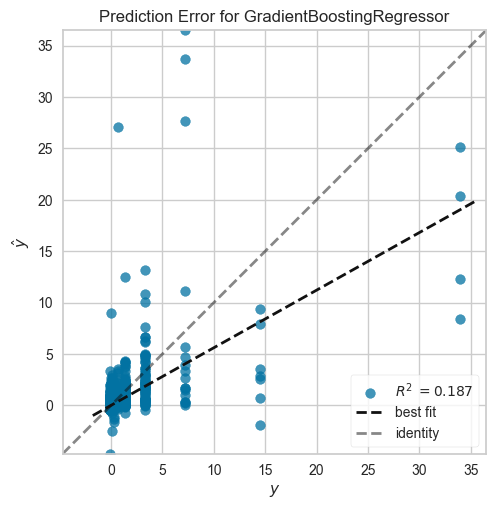

In [7]:
# Visualize the Gradient Boosting Regressor model
plot_model(tuned_gbm_model, plot='error')

In [8]:
predict_model(gbm_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.0652,0.3795,0.6161,0.2042,0.1064,0.6861


,appid,peak_ccu,estimated_owners,prediction_label
41461,1294040,-0.024960,-0.073843,-0.068444
1815,223710,0.017975,3.321932,1.726450
68875,2091120,-0.024960,-0.073843,-0.072316
44118,1373600,-0.024960,-0.073843,-0.068444
33987,1098360,-0.024960,-0.073843,-0.068444
...,...,...,...,...
3441,293600,-0.024960,-0.049518,0.015694
36568,1163990,-0.024960,-0.073843,-0.068444
73328,2226110,-0.024960,-0.083573,-0.072316
62243,1871290,-0.024960,-0.073843,-0.072316


In [9]:
# Save the model using pickle
with open('../data/model/hypothesis1.pkl', 'wb') as file:
    pickle.dump(tuned_gbm_model, file)

# 2. Impact of Platforms on Game Adoption:
- *Theory*: There are more players in games that are accessible on several platforms (Windows, Mac, and Linux).
- *Analysis*: Examine the approximate ownership of games that are accessible across several platforms.

In [10]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT 
                game.estimated_owners,
                game.peak_ccu, 
                platform.windows, 
                platform.mac, 
                platform.linux
            FROM game
            JOIN platform ON game.appid = platform.appid;'''
    query = text(txt)
    result = connection.execute(query)
    platform_df = pd.DataFrame(result.all())

platform_df

,estimated_owners,peak_ccu,windows,mac,linux
0,15000000.0,13230.0,1,1,1
1,7500000.0,110.0,1,1,1
2,7500000.0,106.0,1,1,1
3,7500000.0,2.0,1,1,1
4,7500000.0,120.0,1,1,1
...,...,...,...,...,...
85098,0.0,0.0,1,0,0
85099,0.0,0.0,1,0,0
85100,0.0,0.0,1,0,0
85101,0.0,0.0,1,0,0


Normalize the dataset

In [11]:
# Normalize numerical features using StandardScaler
numerical_columns = platform_df.select_dtypes(include=['float64', 'int64']).columns.difference(['appid'])
scaler = StandardScaler()
platform_df[numerical_columns] = scaler.fit_transform(platform_df[numerical_columns])

# Concatenate 'windows', 'mac', and 'linux' to create a single feature 'platform'
platform_df['platform'] = platform_df['windows'] + platform_df['mac'] + platform_df['linux']

Setup the data for modeling

In [12]:
# Initialize PyCaret
reg_setup = setup(
    data=platform_df,
    target='estimated_owners',
    session_id=42,
    train_size=0.8,
    numeric_features=['peak_ccu', 'platform']
)

# Compare different regression models
reg_models = compare_models()

,Description,Value
0,Session id,42
1,Target,estimated_owners
2,Target type,Regression
3,Original data shape,"(85103, 6)"
4,Transformed data shape,"(85103, 6)"
5,Transformed train set shape,"(68082, 6)"
6,Transformed test set shape,"(17021, 6)"
7,Numeric features,2
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.1132,0.7016,0.7935,0.2226,0.1483,1.0036,0.0280
ridge,Ridge Regression,0.1132,0.7016,0.7935,0.2226,0.1484,1.0019,0.0260
lar,Least Angle Regression,0.1132,0.7016,0.7935,0.2226,0.1484,1.0019,0.0270
br,Bayesian Ridge,0.1132,0.7016,0.7935,0.2226,0.1484,1.0019,0.0260
omp,Orthogonal Matching Pursuit,0.1144,0.7032,0.7944,0.2206,0.1568,0.8871,0.0280
knn,K Neighbors Regressor,0.0912,0.8723,0.8635,0.1396,0.1475,1.0437,0.4200
lightgbm,Light Gradient Boosting Machine,0.0897,0.8414,0.8546,0.1340,0.1415,1.0223,0.1880
huber,Huber Regressor,0.0764,1.0129,0.9167,0.0936,0.1524,0.4778,0.4790
rf,Random Forest Regressor,0.0938,0.9317,0.8962,0.0582,0.1509,0.9692,0.2860
gbr,Gradient Boosting Regressor,0.0911,1.0288,0.9230,0.0446,0.1355,1.0027,0.3080


In [13]:
# Create a Linear Regression model
lr_model = create_model('lr')

# Evaluate the model
evaluate_model(lr_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1170,1.1443,1.0697,0.7223,0.1420,0.9956
1,0.1109,0.5802,0.7617,0.1123,0.1485,1.0622
2,0.1038,0.3261,0.5711,0.1758,0.1412,0.9845
3,0.1136,0.5167,0.7189,0.5676,0.1493,1.0227
4,0.1313,1.4032,1.1846,0.2601,0.1628,0.9483
5,0.1108,0.4044,0.6359,0.2200,0.1508,1.0070
6,0.1033,0.4295,0.6554,0.0697,0.1398,1.0108
7,0.1067,0.3269,0.5718,0.1254,0.1480,0.9951
8,0.1304,1.6552,1.2866,-0.1618,0.1544,0.9762


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

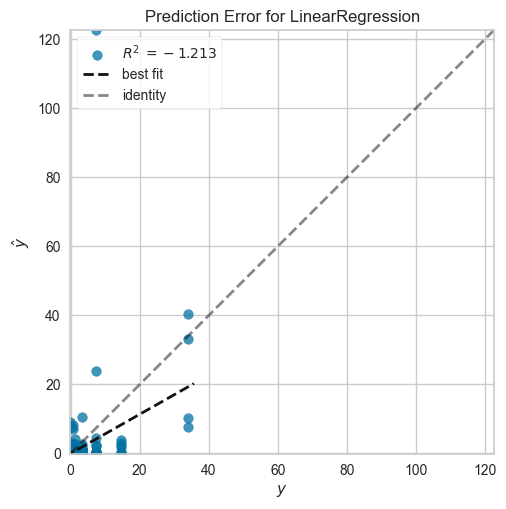

In [14]:
plot_model(lr_model, plot='error')

In [15]:
predict_model(lr_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.1097,1.0555,1.0274,-1.2132,0.1432,0.9825


,peak_ccu,windows,mac,linux,platform,estimated_owners,prediction_label
41461,-0.024960,0.018779,-0.488449,-0.389214,-0.858885,-0.073843,-0.036340
1815,0.017975,0.018779,-0.488449,-0.389214,-0.858885,3.321932,-0.003732
68875,-0.024960,0.018779,-0.488449,-0.389214,-0.858885,-0.073843,-0.036340
44118,-0.024960,0.018779,2.047297,2.569279,4.635355,-0.073843,0.091471
33987,-0.024960,0.018779,2.047297,2.569279,4.635355,-0.073843,0.091471
...,...,...,...,...,...,...,...
3441,-0.024960,0.018779,-0.488449,-0.389214,-0.858885,-0.049518,-0.036340
36568,-0.024960,0.018779,-0.488449,-0.389214,-0.858885,-0.073843,-0.036340
73328,-0.024960,0.018779,-0.488449,-0.389214,-0.858885,-0.083573,-0.036340
62243,-0.024960,0.018779,-0.488449,-0.389214,-0.858885,-0.073843,-0.036340


In [16]:
# Save the model using pickle
with open('../data/model/hypothesis2.pkl', 'wb') as file:
    pickle.dump(lr_model, file)

# 3. Metacritic Score and User Feedback:
- *Theory*: The user and Metacritic scores are positively correlated.
- *Analysis*: Comparison of the user_score and metacritic_score correlation.

In [17]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT
                game.estimated_owners,
                metacritic.metacritic_score,
                user_feedback.user_score
            FROM game
            JOIN metacritic ON game.appid = metacritic.appid
            JOIN user_feedback ON game.appid = user_feedback.appid;'''
    query = text(txt)
    result = connection.execute(query)
    user_score_df = pd.DataFrame(result.all())

user_score_df

,estimated_owners,metacritic_score,user_score
0,15000000.0,88.0,0.0
1,7500000.0,0.0,0.0
2,7500000.0,79.0,0.0
3,7500000.0,0.0,0.0
4,7500000.0,0.0,0.0
...,...,...,...
85098,0.0,0.0,0.0
85099,0.0,0.0,0.0
85100,0.0,0.0,0.0
85101,0.0,0.0,0.0


Normalize the dataset

In [18]:
# Fill NaN values (if needed)
user_score_df = user_score_df.fillna('')

# Normalize numerical features using StandardScaler
numerical_columns = user_score_df.select_dtypes(include=['float64', 'int64']).columns.difference(['appid'])
scaler = StandardScaler()
user_score_df[numerical_columns] = scaler.fit_transform(user_score_df[numerical_columns])

Setup the data for modeling

In [19]:
# Initialize PyCaret for regression
reg_setup = setup(
    data=user_score_df,
    target='estimated_owners',
    session_id=42,
    numeric_features=['metacritic_score', 'user_score']
)

# Compare different regression models
reg_models = compare_models()

,Description,Value
0,Session id,42
1,Target,estimated_owners
2,Target type,Regression
3,Original data shape,"(85103, 3)"
4,Transformed data shape,"(85103, 3)"
5,Transformed train set shape,"(59572, 3)"
6,Transformed test set shape,"(25531, 3)"
7,Numeric features,2
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.1118,0.7857,0.8403,0.0475,0.1654,1.3296,0.0130
lar,Least Angle Regression,0.1118,0.7857,0.8403,0.0475,0.1654,1.3296,0.0110
omp,Orthogonal Matching Pursuit,0.1118,0.7857,0.8403,0.0475,0.1654,1.3296,0.0110
br,Bayesian Ridge,0.1118,0.7857,0.8403,0.0475,0.1653,1.3292,0.0120
ridge,Ridge Regression,0.1118,0.7857,0.8403,0.0475,0.1654,1.3296,0.0120
lightgbm,Light Gradient Boosting Machine,0.1097,0.7712,0.8384,0.0282,0.1622,1.1530,0.0930
huber,Huber Regressor,0.0745,0.8120,0.8553,0.0095,0.1609,0.4648,0.1000
en,Elastic Net,0.1289,0.8171,0.8586,-0.0004,0.1835,1.0028,0.0110
llar,Lasso Least Angle Regression,0.1289,0.8171,0.8586,-0.0004,0.1835,1.0028,0.0120
lasso,Lasso Regression,0.1289,0.8171,0.8586,-0.0004,0.1835,1.0028,0.0110


In [20]:
# Create a Linear Regression model
lr_model = create_model('lr')

# Evaluate the model
evaluate_model(lr_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1057,0.6858,0.8281,0.0473,0.1559,1.3103
1,0.1059,0.4236,0.6508,0.0315,0.1633,1.3522
2,0.1198,1.3101,1.1446,0.0285,0.1723,1.1941
3,0.1370,1.8845,1.3728,0.0323,0.1891,1.1844
4,0.1165,0.6749,0.8216,0.0458,0.1749,1.4473
5,0.0971,0.1745,0.4177,0.1119,0.1448,1.4764
6,0.1046,0.7029,0.8384,0.0312,0.1584,1.2386
7,0.1185,1.2201,1.1046,0.0402,0.1688,1.3694
8,0.1103,0.5426,0.7366,0.0261,0.1680,1.4121


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

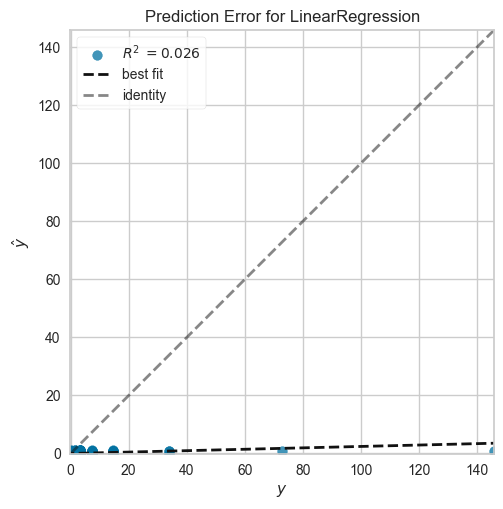

In [21]:
plot_model(lr_model, plot='error')

In [22]:
predict_model(lr_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.1118,1.3892,1.1786,0.0264,0.1637,1.2981


,metacritic_score,user_score,estimated_owners,prediction_label
41461,-0.217125,-0.022235,-0.073843,-0.038642
1815,-0.217125,-0.022235,3.321932,-0.038642
68875,-0.217125,-0.022235,-0.073843,-0.038642
44118,-0.217125,-0.022235,-0.073843,-0.038642
33987,-0.217125,-0.022235,-0.073843,-0.038642
...,...,...,...,...
12529,-0.217125,-0.022235,-0.073843,-0.038642
17324,-0.217125,-0.022235,0.256977,-0.038642
66325,-0.217125,-0.022235,-0.083573,-0.038642
60472,-0.217125,-0.022235,-0.049518,-0.038642


In [23]:
# Save the model using pickle
with open('../data/model/hypothesis3.pkl', 'wb') as file:
    pickle.dump(lr_model, file)

# 4. Effect of Game Features on Reviews:
- *Theory*: There are more achievements in games that have received favorable reviews.
- *Analysis*: Examine the typical quantity of achievements in games that have both favorable and unfavorable evaluations.

In [24]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT
                positive,
                negative,
                achievements
            FROM user_feedback;'''
    query = text(txt)
    result = connection.execute(query)
    feedback_df = pd.DataFrame(result.all())

feedback_df

,positive,negative,achievements
0,198387.0,5135.0,0.0
1,5677.0,923.0,0.0
2,5179.0,566.0,0.0
3,1929.0,428.0,0.0
4,14333.0,718.0,0.0
...,...,...,...
85098,0.0,0.0,0.0
85099,0.0,0.0,0.0
85100,0.0,0.0,0.0
85101,0.0,0.0,0.0


Normalize the dataset

In [25]:
# Fill NaN values with an empty string (if needed)
feedback_df = feedback_df.fillna('')

# Normalize numerical features using StandardScaler
numerical_columns = feedback_df.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
feedback_df[numerical_columns] = scaler.fit_transform(feedback_df[numerical_columns])

Setup the data for modeling

In [26]:
# Initialize PyCaret for regression
reg_setup = setup(
    data=feedback_df,
    target='positive',  # Assuming 'positive' is the target variable
    session_id=42
)

# Compare different regression models
reg_models = compare_models()

,Description,Value
0,Session id,42
1,Target,positive
2,Target type,Regression
3,Original data shape,"(85103, 3)"
4,Transformed data shape,"(85103, 3)"
5,Transformed train set shape,"(59572, 3)"
6,Transformed test set shape,"(25531, 3)"
7,Numeric features,2
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,0.0279,0.1630,0.3741,0.5465,0.0714,0.6833,0.1410
lightgbm,Light Gradient Boosting Machine,0.0285,0.1825,0.3906,0.4918,0.0701,0.7627,0.1010
rf,Random Forest Regressor,0.0291,0.1805,0.4017,0.4832,0.0729,0.7306,0.4280
gbr,Gradient Boosting Regressor,0.0274,0.1798,0.4012,0.4817,0.0665,0.7061,0.2450
et,Extra Trees Regressor,0.0291,0.1731,0.3975,0.4567,0.0744,0.7151,0.2560
dt,Decision Tree Regressor,0.0330,0.2352,0.4701,0.2613,0.0859,0.7431,0.0190
ada,AdaBoost Regressor,0.0848,0.2694,0.4833,0.1465,0.1222,2.3144,0.1200
huber,Huber Regressor,0.0255,0.4037,0.4876,0.1168,0.0656,0.4890,0.0570
en,Elastic Net,0.0661,0.3631,0.5723,-0.0002,0.1268,0.9619,0.0110
llar,Lasso Least Angle Regression,0.0661,0.3631,0.5723,-0.0002,0.1268,0.9619,0.0110


In [27]:
# Create a K Neighbors Regressor model
knn_model = create_model('knn')

# Evaluate the model
evaluate_model(knn_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0254,0.0977,0.3126,0.6523,0.0659,1.0692
1,0.0267,0.0743,0.2725,0.4086,0.0776,0.4549
2,0.0343,0.1796,0.4238,0.6684,0.0800,0.6071
3,0.0460,0.5466,0.7393,0.4200,0.0952,0.5074
4,0.0234,0.0451,0.2125,0.8488,0.0634,0.3181
5,0.0210,0.1125,0.3354,0.3643,0.0619,1.2880
6,0.0280,0.2948,0.5430,0.4729,0.0671,0.5414
7,0.0277,0.1325,0.3641,0.6460,0.0715,0.8656
8,0.0214,0.0586,0.2420,0.7225,0.0602,0.4809


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

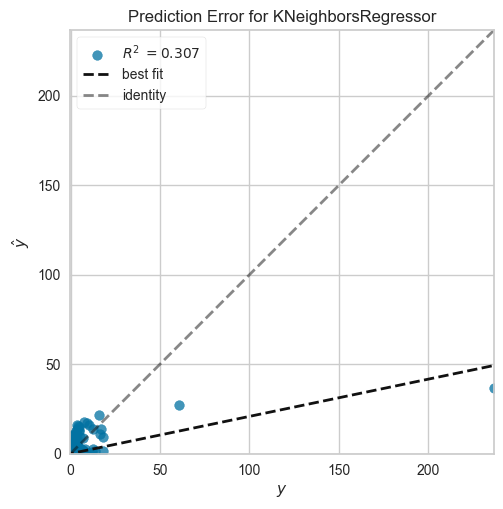

In [28]:
plot_model(knn_model, plot='error')

In [29]:
predict_model(knn_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.0371,1.7223,1.3124,0.3072,0.0764,0.5473


,negative,achievements,positive,prediction_label
41461,-0.032522,-0.098337,-0.038777,-0.038875
1815,1.208473,-0.115835,1.410787,2.722603
68875,-0.034926,-0.115835,-0.039351,-0.039294
44118,-0.034708,0.024151,-0.038982,-0.038489
33987,-0.034926,0.088311,-0.039310,-0.038974
...,...,...,...,...
12529,-0.029461,-0.063340,-0.037340,-0.034704
17324,0.087708,-0.115835,-0.002732,0.064947
66325,-0.034926,-0.115835,-0.039351,-0.039294
60472,-0.033615,0.047482,-0.038366,-0.037315


In [30]:
# Save the model using pickle
with open('../data/model/hypothesis4.pkl', 'wb') as file:
    pickle.dump(knn_model, file)

# 5. Playtime Patterns:
- *Theory*: Games with longer median playtimes also have longer average playtimes.
- *Analysis*: Comparison of average_playtime_forever and median_playtime_forever by correlation analysis.

In [31]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT
                average_playtime_forever,
                median_playtime_forever
            FROM
                playtime;'''
    query = text(txt)
    result = connection.execute(query)
    playtime_df = pd.DataFrame(result.all())

playtime_df

,average_playtime_forever,median_playtime_forever
0,10524.0,228.0
1,143.0,23.0
2,1397.0,27.0
3,945.0,10.0
4,214.0,66.0
...,...,...
85098,0.0,0.0
85099,0.0,0.0
85100,0.0,0.0
85101,0.0,0.0


Normalize the dataset

In [32]:
# Fill NaN values with an empty string (if needed)
playtime_df = playtime_df.fillna('')

# Normalize numerical features using StandardScaler
numerical_columns = playtime_df.select_dtypes(include=['float64', 'int64']).columns.difference(['appid'])
scaler = StandardScaler()
playtime_df[numerical_columns] = scaler.fit_transform(playtime_df[numerical_columns])

Setup the data for modeling

In [33]:
# Initialize PyCaret for regression
reg_setup = setup(
    data=playtime_df,
    target='average_playtime_forever',  # Assuming 'average_playtime_forever' is the target variable
    session_id=42
)

# Compare different regression models
reg_models = compare_models()

,Description,Value
0,Session id,42
1,Target,average_playtime_forever
2,Target type,Regression
3,Original data shape,"(85103, 2)"
4,Transformed data shape,"(85103, 2)"
5,Transformed train set shape,"(59572, 2)"
6,Transformed test set shape,"(25531, 2)"
7,Numeric features,1
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0722,0.2592,0.4941,0.7274,0.1035,0.4700,0.0120
ridge,Ridge Regression,0.0722,0.2592,0.4941,0.7274,0.1035,0.4700,0.0110
lar,Least Angle Regression,0.0722,0.2592,0.4941,0.7274,0.1035,0.4700,0.0110
omp,Orthogonal Matching Pursuit,0.0722,0.2592,0.4941,0.7274,0.1035,0.4700,0.0110
br,Bayesian Ridge,0.0722,0.2592,0.4941,0.7274,0.1035,0.4700,0.0110
knn,K Neighbors Regressor,0.0523,0.2894,0.5065,0.7185,0.1094,0.6198,0.4980
rf,Random Forest Regressor,0.0540,0.3197,0.5376,0.6779,0.1080,0.5601,0.2130
et,Extra Trees Regressor,0.0556,0.3478,0.5620,0.6555,0.1097,0.5756,0.1070
gbr,Gradient Boosting Regressor,0.0501,0.3880,0.5801,0.6338,0.0920,0.4995,0.2200
huber,Huber Regressor,0.0388,0.4163,0.5940,0.5724,0.0914,0.1230,0.0660


In [34]:
# Create a Linear Regression model
lr_model = create_model('lr')

# Evaluate the model
evaluate_model(lr_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0685,0.1482,0.3850,0.6593,0.1026,0.4823
1,0.0758,0.1701,0.4124,0.6242,0.1208,0.4402
2,0.0856,0.5599,0.7483,0.8230,0.1107,0.5027
3,0.0731,0.4350,0.6595,0.8387,0.0962,0.4470
4,0.0702,0.1380,0.3715,0.7019,0.1054,0.5415
5,0.0701,0.2784,0.5276,0.5697,0.0994,0.4730
6,0.0685,0.2456,0.4955,0.8423,0.0883,0.4250
7,0.0677,0.1358,0.3686,0.7315,0.1028,0.4343
8,0.0750,0.3027,0.5501,0.7632,0.1077,0.5127


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

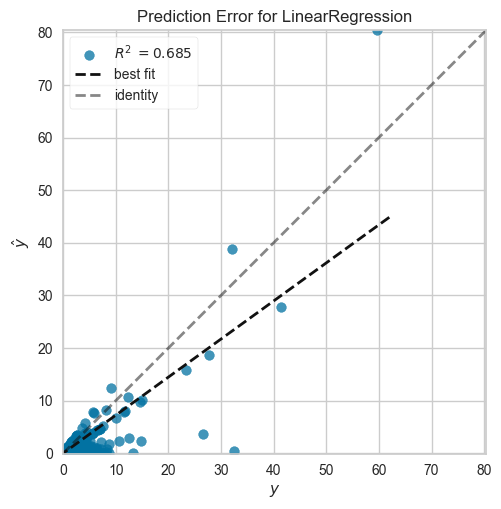

In [35]:
plot_model(lr_model, plot='error')

In [36]:
predict_model(lr_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0684,0.1797,0.4239,0.6854,0.1019,0.4738


,median_playtime_forever,average_playtime_forever,prediction_label
41461,-0.061769,-0.091672,-0.054683
1815,-0.027349,0.077265,-0.023989
68875,-0.061769,-0.091672,-0.054683
44118,-0.061769,-0.091672,-0.054683
33987,-0.061769,-0.091672,-0.054683
...,...,...,...
12529,-0.061769,-0.091672,-0.054683
17324,-0.051840,-0.079417,-0.045829
66325,-0.061769,-0.091672,-0.054683
60472,-0.061769,-0.091672,-0.054683


In [37]:
# Save the model using pickle
with open('../data/model/hypothesis5.pkl', 'wb') as file:
    pickle.dump(lr_model, file)

# 6. Price Influence
- *Theory*: User scores for games are typically higher when they are more expensive.
- *Analysis*: Examine average user scores for various price ranges of games.

In [38]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT 
                game.price, 
                user_feedback.user_score
            FROM game
            JOIN user_feedback ON game.appid = user_feedback.appid;'''
    query = text(txt)
    result = connection.execute(query)
    price_df = pd.DataFrame(result.all())

price_df

,price,user_score
0,9.99,0.0
1,4.99,0.0
2,4.99,0.0
3,4.99,0.0
4,4.99,0.0
...,...,...
85098,0.00,0.0
85099,0.00,0.0
85100,0.00,0.0
85101,0.00,0.0


Normalize the dataset

In [39]:
# Fill NaN values with an empty string (if needed)
price_df = price_df.fillna('')

# Assuming price and user_score are the columns you want to filter
price_df.drop(price_df[price_df['user_score'] == 0].index, inplace=True)

# Normalize numerical features using StandardScaler
numerical_columns = price_df.select_dtypes(include=['float64', 'int64']).columns.difference(['appid'])
scaler = StandardScaler()
price_df[['price', 'user_score']] = scaler.fit_transform(price_df[['price', 'user_score']])

Setup the data for modeling

In [40]:
# Initialize PyCaret for regression
reg_setup = setup(
    data=price_df,
    target='user_score',  # Assuming 'user_score' is the target variable
    session_id=42
)

# Compare different regression models
reg_models = compare_models()

,Description,Value
0,Session id,42
1,Target,user_score
2,Target type,Regression
3,Original data shape,"(44, 2)"
4,Transformed data shape,"(44, 2)"
5,Transformed train set shape,"(30, 2)"
6,Transformed test set shape,"(14, 2)"
7,Numeric features,1
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,1.0407,1.3951,1.1573,-3.6208,0.5507,6.9623,0.0050
omp,Orthogonal Matching Pursuit,1.0411,1.3967,1.1579,-3.6214,0.5473,7.0372,0.0050
lr,Linear Regression,1.0411,1.3967,1.1579,-3.6214,0.5473,7.0372,0.0050
lar,Least Angle Regression,1.0411,1.3967,1.1579,-3.6214,0.5473,7.0372,0.0050
en,Elastic Net,1.0359,1.3599,1.1411,-3.7214,0.6214,4.4693,0.0050
lasso,Lasso Regression,1.0359,1.3599,1.1411,-3.7214,0.6214,4.4693,0.0050
dummy,Dummy Regressor,1.0359,1.3599,1.1411,-3.7214,0.6214,4.4693,0.0070
lightgbm,Light Gradient Boosting Machine,1.0359,1.3599,1.1411,-3.7214,0.6214,4.4693,0.0130
llar,Lasso Least Angle Regression,1.0359,1.3599,1.1411,-3.7214,0.6214,4.4693,0.0050
br,Bayesian Ridge,1.0619,1.4302,1.1717,-3.9233,0.5942,5.0811,0.0050


In [41]:
# Create a Ridge Regression model
ridge_model = create_model('ridge')

# Evaluate the Ridge Regression model
evaluate_model(ridge_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8394,1.0215,1.0107,-3.6264,0.5083,0.8121
1,1.1194,1.5005,1.2250,-0.0188,0.6436,0.9063
2,0.5743,0.5739,0.7576,-1.1699,0.3494,2.9100
3,1.3648,1.8877,1.3739,-0.0116,0.8145,0.9266
4,1.2006,2.1539,1.4676,-1.9589,0.4292,0.8699
5,1.1354,1.3812,1.1752,-14.8114,0.7271,0.9349
6,1.1950,1.7861,1.3365,-10.2668,0.4135,1.1889
7,1.2267,1.5210,1.2333,-0.1335,0.6290,1.0288
8,1.0846,1.5870,1.2598,-2.1699,0.5912,1.6309


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

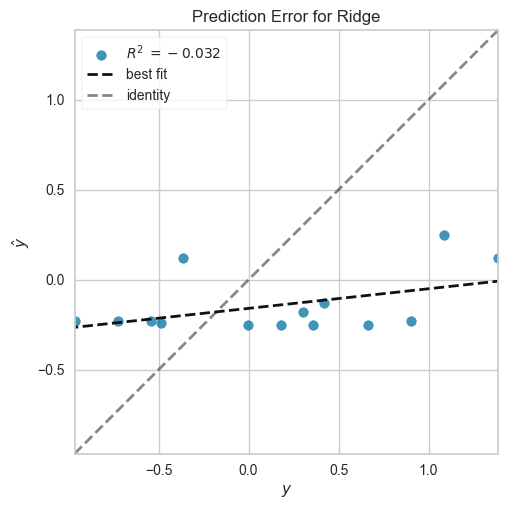

In [42]:
plot_model(ridge_model, plot='error')

In [43]:
predict_model(ridge_model)

,price,user_score,prediction_label
28713,-0.699260,0.179618,-0.253710
26923,-0.589681,-0.725328,-0.228907
26956,-0.589681,0.903575,-0.228907
28683,0.959927,1.386213,0.121843
28142,-0.589681,-0.966647,-0.228907
29169,0.959927,-0.363350,0.121843
13145,1.513358,1.084564,0.247110
19242,-0.699260,-0.001371,-0.253710
14960,-0.699260,0.360607,-0.253710
12972,-0.368309,0.300278,-0.178800


In [44]:
# Save the model using pickle
with open('../data/model/hypothesis6.pkl', 'wb') as file:
    pickle.dump(ridge_model, file)

# 7. Categorization Impact on Popularity
- *Theory*: Owner estimates of games tend to be higher for those with more categories and genres.
- *Analysis*: Look at the connection between estimated owners and the number of categories/genres.

In [45]:
with engine.connect() as connection:
    # Query to extract relevant columns
    txt = '''SELECT 
                game.appid, 
                game.estimated_owners, 
                categorization.categories, 
                categorization.genres
            FROM game
            JOIN categorization ON game.appid = categorization.appid;'''
    query = text(txt)
    result = connection.execute(query)
    category_df = pd.DataFrame(result.all())

category_df

,appid,estimated_owners,categories,genres
0,10,15000000.0,"Multi-player,PvP,Online PvP,Shared/Split Scree...",Action
1,20,7500000.0,"Multi-player,PvP,Online PvP,Shared/Split Scree...",Action
2,30,7500000.0,"Multi-player,Valve Anti-Cheat enabled",Action
3,40,7500000.0,"Multi-player,PvP,Online PvP,Shared/Split Scree...",Action
4,50,7500000.0,"Single-player,Multi-player,Valve Anti-Cheat en...",Action
...,...,...,...,...
85098,2760980,0.0,unknown,unknown
85099,2761170,0.0,unknown,unknown
85100,2763480,0.0,unknown,unknown
85101,2764930,0.0,unknown,unknown


Normalize the dataset

In [46]:
# # Download NLTK stopwords data
# nltk.download('stopwords')

# Columns to convert to lists
columns_to_convert = [ 'categories', 'genres']

# Fill NaN values with an empty string
category_df[columns_to_convert] = category_df[columns_to_convert].fillna('')

# Normalize numerical features using StandardScaler
numerical_columns = category_df.select_dtypes(include=['float64', 'int64']).columns.difference(['appid'])
scaler = StandardScaler()
category_df[numerical_columns] = scaler.fit_transform(category_df[numerical_columns])

# One-hot encode categorical features
categorical_columns = category_df.select_dtypes(include=['bool']).columns.difference(['appid'])
category_df = pd.get_dummies(category_df, columns=categorical_columns, drop_first=True)

category_df.drop(columns='genres', inplace=True)

# # Use CountVectorizer to convert text columns to bag-of-words representation
# count_vectorizer = CountVectorizer(stop_words=stopwords.words('english'))  # Use English stopwords
# for column in columns_to_convert:
#     column_bow = count_vectorizer.fit_transform(category_df[column])
#     category_df = pd.concat([category_df, pd.DataFrame(column_bow.toarray(), columns=count_vectorizer.get_feature_names_out([column]))], axis=1)

category_df

,appid,estimated_owners,categories
0,10,14.511447,"Multi-player,PvP,Online PvP,Shared/Split Scree..."
1,20,7.213937,"Multi-player,PvP,Online PvP,Shared/Split Scree..."
2,30,7.213937,"Multi-player,Valve Anti-Cheat enabled"
3,40,7.213937,"Multi-player,PvP,Online PvP,Shared/Split Scree..."
4,50,7.213937,"Single-player,Multi-player,Valve Anti-Cheat en..."
...,...,...,...
85098,2760980,-0.083573,unknown
85099,2761170,-0.083573,unknown
85100,2763480,-0.083573,unknown
85101,2764930,-0.083573,unknown


Setup the data for modeling

In [47]:
# Initialize PyCaret setup
reg_setup = setup(
    data=category_df,
    target='estimated_owners',
    train_size=0.8,
    session_id=42,
    numeric_features=[],  # Specify numeric features if needed
    categorical_features=['categories'],  # Specify categorical features
    ignore_features=['appid'],  # Specify features to ignore
    fold=5,  # Specify the number of folds for cross-validation
    # normalize=True,
    # transformation=True,
    # transform_target=True
)

# Compare different regression models
reg_models = compare_models()

,Description,Value
0,Session id,42
1,Target,estimated_owners
2,Target type,Regression
3,Original data shape,"(85103, 3)"
4,Transformed data shape,"(85103, 2)"
5,Transformed train set shape,"(68082, 2)"
6,Transformed test set shape,"(17021, 2)"
7,Ignore features,1
8,Categorical features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.0792,1.1312,1.0204,0.0001,0.1643,0.4339,0.0800
llar,Lasso Least Angle Regression,0.1316,1.1308,1.0204,-0.0002,0.1833,1.0258,0.0300
lasso,Lasso Regression,0.1316,1.1308,1.0204,-0.0002,0.1833,1.0258,0.0620
dummy,Dummy Regressor,0.1316,1.1308,1.0204,-0.0002,0.1833,1.0258,0.0260
en,Elastic Net,0.1316,1.1308,1.0204,-0.0002,0.1833,1.0258,0.0520
rf,Random Forest Regressor,0.0966,1.1652,1.0351,-0.0283,0.1724,0.8326,0.3220
dt,Decision Tree Regressor,0.0967,1.1655,1.0354,-0.0293,0.1726,0.8338,0.0480
et,Extra Trees Regressor,0.0967,1.1655,1.0354,-0.0293,0.1726,0.8339,0.1440
gbr,Gradient Boosting Regressor,0.0980,1.1663,1.0360,-0.0309,0.1726,0.8695,0.2660
ada,AdaBoost Regressor,0.1111,1.1705,1.0385,-0.0381,0.1761,0.8815,0.0500


In [48]:
# Create a Huber Regressor model
huber_model = create_model('huber')

# Evaluate the Huber Regressor model
evaluate_model(huber_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0844,2.3893,1.5457,-0.0008,0.1645,0.4431
1,0.0768,0.7957,0.8920,-0.0004,0.1642,0.4324
2,0.0929,1.2092,1.0996,-0.0013,0.1833,0.4477
3,0.0654,0.4163,0.6452,0.0035,0.1488,0.4178
4,0.0765,0.8454,0.9194,-0.0004,0.1609,0.4287
Mean,0.0792,1.1312,1.0204,0.0001,0.1643,0.4339
Std,0.0091,0.6774,0.2999,0.0017,0.0111,0.0106


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

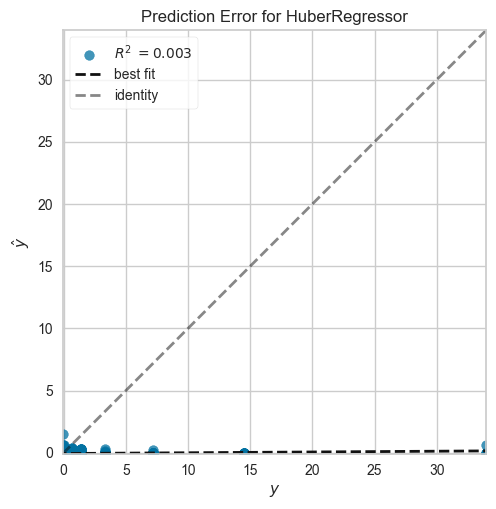

In [49]:
plot_model(huber_model, plot='error')

In [50]:
predict_model(huber_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.0712,0.4754,0.6895,0.0032,0.1591,0.4401


,categories,estimated_owners,prediction_label
41461,"Single-player,Steam Achievements,Partial Contr...",-0.073843,-0.071715
1815,"Single-player,Multi-player,Co-op,Steam Cloud,V...",3.321932,-0.052552
68875,Single-player,-0.073843,-0.074709
44118,"Single-player,Steam Achievements,Full controll...",-0.073843,-0.069143
33987,Single-player,-0.073843,-0.074709
...,...,...,...
3441,"Single-player,Multi-player,Shared/Split Screen...",-0.049518,-0.058009
36568,"Single-player,Multi-player,Co-op,Shared/Split ...",-0.073843,-0.068147
73328,"Single-player,Multi-player,PvP,Shared/Split Sc...",-0.083573,-0.073168
62243,Single-player,-0.073843,-0.074709


In [51]:
# Save the model using pickle
with open('../data/model/hypothesis7.pkl', 'wb') as file:
    pickle.dump(huber_model, file)